In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
import pandas as pd
import numpy as np
import time
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [4]:
data = pd.read_csv("extraCombined.csv")

In [ ]:
features = ['Volume', 'Carbon Intensity', 'Average Temperature', 'Price']

In [ ]:
features = ['Carbon Intensity', 'Average Temperature', 'Imbalance Price Amount']

In [10]:
target = ['Price']

In [9]:
target = ['Imbalance Price Amount']

In [5]:
input_dim = len(features)
d_model = 200
nhead = 10
num_layers = 4
dropout = 0.5

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_model * 2, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 77)  # Adjust output dimension to predict 48 prices

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # Only use the final timestep for decoding
        return self.decoder(output[-1])

In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])
scaled_target = scaler.fit_transform(data[target])

# Split the data
train_size = int(0.95* len(scaled_features))
train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

# Reshape the data to sequences
sequence_length = 298  # Half-hour periods in a day
forecast_horizon = 77  # Predict the next 48 prices

train_data = [(train_features[i:i+sequence_length], train_target[i:i+sequence_length + forecast_horizon]) for i in range(len(train_features)-sequence_length-forecast_horizon)]
test_data = [(test_features[i:i+sequence_length], test_target[i:i+sequence_length + forecast_horizon]) for i in range(len(test_features)-sequence_length-forecast_horizon)]


In [ ]:
print(np.array(test_data[0]))

(2,)


<ipython-input-72-562a29a3de6b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(test_data[0]).shape)


In [12]:
criterion = nn.L1Loss()

In [13]:
def evaluate(eval_model, data_source):
    eval_model.eval()
    total_loss = 0.
    with torch.no_grad():
        for feature_batch, target_batch in data_source:
            data = torch.from_numpy(feature_batch).float().to(device)
            targets = torch.stack([torch.from_numpy(target_batch[i:i+forecast_horizon]).float() for i in range(sequence_length)], dim=0).to(device)
            output = eval_model(data)
            total_loss += len(data) * criterion(output, targets.squeeze()).cpu().item()
    return total_loss / (len(data_source) - 1)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim, d_model, nhead, num_layers, dropout).to(device)
model.load_state_dict(torch.load('Vas_AIMLAC_best_weightsDAYAHEAD_run1.pth', map_location=device))

<All keys matched successfully>

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
scaler = StandardScaler()


In [15]:
single_input, actual_values = test_data[0]
single_input = torch.from_numpy(single_input).float().unsqueeze(1).to(device)  # Add batch dimension


In [ ]:
(scaler.inverse_transform(actual_values[:77]))

array([[141.75   ],
       [142.     ],
       [138.     ],
       [137.9    ],
       [134.     ],
       [134.     ],
       [137.95   ],
       [140.     ],
       [135.     ],
       [140.     ],
       [140.     ],
       [139.9    ],
       [134.     ],
       [134.     ],
       [134.     ],
       [144.     ],
       [ 65.1    ],
       [150.     ],
       [157.37004],
       [161.     ],
       [173.5    ],
       [169.1    ],
       [169.1    ],
       [174.1    ],
       [184.     ],
       [178.5    ],
       [174.2    ],
       [174.1    ],
       [ 78.35   ],
       [ 78.     ],
       [ 78.     ],
       [184.     ],
       [175.     ],
       [174.     ],
       [100.     ],
       [185.     ],
       [194.     ],
       [189.     ],
       [189.     ],
       [174.     ],
       [ 78.4    ],
       [174.     ],
       [185.     ],
       [174.     ],
       [195.     ],
       [ 78.4    ],
       [174.     ],
       [183.5    ],
       [195.     ],
       [183.5    ],


In [ ]:
print(single_input)

tensor([[[ 0.0229,  1.2288,  1.9518]],

        [[-0.0334,  1.2288,  1.9518]],

        [[-0.0757,  1.2288,  0.8350]],

        [[-0.0898,  1.5980,  0.8903]],

        [[-0.0475,  1.5980,  0.8903]],

        [[-0.0194,  1.5980,  1.9518]],

        [[-0.0194,  1.5980,  0.8903]],

        [[ 0.0229,  1.5980,  1.9518]],

        [[ 0.0934,  1.5980,  1.9518]],

        [[ 0.1920,  1.5980,  1.9518]],

        [[ 0.2765,  1.5980,  1.9518]],

        [[ 0.3470,  1.5980,  2.2625]],

        [[ 0.4033,  1.5980,  2.2726]],

        [[ 0.4597,  1.5980,  2.8550]],

        [[ 0.5724,  1.5980,  3.1518]],

        [[ 0.7133,  1.5980,  3.0337]],

        [[ 0.8260,  1.5980,  2.9602]],

        [[ 0.9106,  1.5980,  3.0794]],

        [[ 0.9528,  1.5980,  3.1081]],

        [[ 0.9388,  1.5980,  3.0544]],

        [[ 0.9669,  1.5980,  3.0319]],

        [[ 1.0374,  1.5980,  2.9000]],

        [[ 1.0656,  1.5980,  0.9208]],

        [[ 1.0656,  1.5980,  1.2134]],

        [[ 1.1360,  1.5980,  1.2134]],



In [16]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    prediction = model(single_input)

In [ ]:
print(prediction)

tensor([[ 0.7005,  0.5646,  0.4614,  0.3006,  0.1583, -0.0016, -0.0911, -0.1758,
         -0.2321, -0.2910, -0.3368, -0.3589, -0.3467, -0.3154, -0.2681, -0.2268,
         -0.1664, -0.0717,  0.0130,  0.1220,  0.2283,  0.3214,  0.3994,  0.4774,
          0.5668,  0.6277,  0.6451,  0.6264,  0.5858,  0.5544,  0.5047,  0.4639,
          0.4078,  0.3751,  0.3177,  0.2640,  0.2134,  0.1841,  0.1523,  0.1430,
          0.1610,  0.1821,  0.2018,  0.2182,  0.2290,  0.2413,  0.2604,  0.2725,
          0.2820,  0.2835,  0.2729,  0.2403,  0.1986,  0.1228,  0.0577, -0.0027,
         -0.0468, -0.0675, -0.1063, -0.1226, -0.1264, -0.1098, -0.0979, -0.0823,
         -0.0832, -0.0490,  0.0037,  0.1068,  0.1636,  0.2355,  0.3029,  0.3644,
          0.3863,  0.3878,  0.3845,  0.3735,  0.3856]])


In [17]:
actual_values_np = actual_values.reshape(-1, 1)
original_scale_actual_values = scaler.inverse_transform(actual_values_np)

In [18]:
prediction_np = prediction.cpu().numpy().reshape(-1, 1)
original_scale_prediction = scaler.inverse_transform(prediction_np)

In [ ]:
print(original_scale_prediction)

[[165.12703 ]
 [150.33157 ]
 [139.1024  ]
 [121.59123 ]
 [106.09983 ]
 [ 88.68242 ]
 [ 78.94305 ]
 [ 69.71805 ]
 [ 63.594097]
 [ 57.179214]
 [ 52.191036]
 [ 49.78454 ]
 [ 51.10931 ]
 [ 54.5195  ]
 [ 59.67033 ]
 [ 64.16389 ]
 [ 70.74373 ]
 [ 81.05536 ]
 [ 90.271324]
 [102.14678 ]
 [113.71389 ]
 [123.85729 ]
 [132.34418 ]
 [140.83894 ]
 [150.56953 ]
 [157.20238 ]
 [159.09431 ]
 [157.0602  ]
 [152.64565 ]
 [149.22673 ]
 [143.80713 ]
 [139.37341 ]
 [133.26297 ]
 [129.69597 ]
 [123.45227 ]
 [117.60952 ]
 [112.09089 ]
 [108.90127 ]
 [105.439766]
 [104.434715]
 [106.393074]
 [108.691414]
 [110.83004 ]
 [112.61391 ]
 [113.796616]
 [115.12942 ]
 [117.209885]
 [118.53145 ]
 [119.5621  ]
 [119.72617 ]
 [118.57805 ]
 [115.02594 ]
 [110.482765]
 [102.233955]
 [ 95.1447  ]
 [ 88.565765]
 [ 83.76225 ]
 [ 81.507904]
 [ 77.283875]
 [ 75.51623 ]
 [ 75.10292 ]
 [ 76.90091 ]
 [ 78.20508 ]
 [ 79.8995  ]
 [ 79.79828 ]
 [ 83.523705]
 [ 89.263565]
 [100.48765 ]
 [106.6783  ]
 [114.50048 ]
 [121.83662 ]
 [128.

In [ ]:
print(original_scale_actual_values[:77])

[[141.75   ]
 [142.     ]
 [138.     ]
 [137.9    ]
 [134.     ]
 [134.     ]
 [137.95   ]
 [140.     ]
 [135.     ]
 [140.     ]
 [140.     ]
 [139.9    ]
 [134.     ]
 [134.     ]
 [134.     ]
 [144.     ]
 [ 65.1    ]
 [150.     ]
 [157.37004]
 [161.     ]
 [173.5    ]
 [169.1    ]
 [169.1    ]
 [174.1    ]
 [184.     ]
 [178.5    ]
 [174.2    ]
 [174.1    ]
 [ 78.35   ]
 [ 78.     ]
 [ 78.     ]
 [184.     ]
 [175.     ]
 [174.     ]
 [100.     ]
 [185.     ]
 [194.     ]
 [189.     ]
 [189.     ]
 [174.     ]
 [ 78.4    ]
 [174.     ]
 [185.     ]
 [174.     ]
 [195.     ]
 [ 78.4    ]
 [174.     ]
 [183.5    ]
 [195.     ]
 [183.5    ]
 [195.     ]
 [195.     ]
 [195.     ]
 [195.     ]
 [183.5    ]
 [183.5    ]
 [183.5    ]
 [170.     ]
 [136.47   ]
 [119.41013]
 [ 78.6    ]
 [ 80.     ]
 [ 80.5    ]
 [170.     ]
 [ 78.4    ]
 [174.98015]
 [224.     ]
 [224.     ]
 [224.     ]
 [224.     ]
 [224.     ]
 [175.     ]
 [176.7704 ]
 [175.     ]
 [101.     ]
 [ 76.     ]
 [180.     ]

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
mean_absolute_error(original_scale_actual_values[:77], original_scale_prediction)

10.498143207500505

In [ ]:
print()

In [ ]:
print(original_scale_actual_values[-77:])

[[181.     ]
 [180.     ]
 [173.01   ]
 [173.01   ]
 [182.51   ]
 [182.5    ]
 [182.     ]
 [398.89993]
 [279.62   ]
 [398.9    ]
 [309.94   ]
 [379.8999 ]
 [190.     ]
 [390.     ]
 [352.46872]
 [185.05   ]
 [186.     ]
 [185.2    ]
 [272.     ]
 [186.     ]
 [280.     ]
 [186.     ]
 [186.     ]
 [264.     ]
 [264.     ]
 [269.     ]
 [269.     ]
 [269.     ]
 [269.     ]
 [186.     ]
 [269.     ]
 [186.     ]
 [186.     ]
 [121.2    ]
 [180.     ]
 [170.     ]
 [121.2    ]
 [121.2    ]
 [270.     ]
 [270.     ]
 [261.     ]
 [121.2    ]
 [250.     ]
 [121.2    ]
 [121.2    ]
 [101.     ]
 [101.     ]
 [116.     ]
 [115.4    ]
 [260.     ]
 [260.     ]
 [260.     ]
 [152.5    ]
 [310.     ]
 [309.98   ]
 [310.     ]
 [325.     ]
 [325.     ]
 [310.     ]
 [310.     ]
 [153.     ]
 [152.51   ]
 [116.     ]
 [152.51   ]
 [255.     ]
 [243.9    ]
 [151.     ]
 [122.     ]
 [243.9    ]
 [122.     ]
 [122.     ]
 [122.     ]
 [122.     ]
 [122.     ]
 [122.     ]
 [140.     ]
 [122.     ]

In [ ]:
print(original_scale_prediction)

[[344.1465 ]
 [272.17017]
 [247.81035]
 [219.49312]
 [187.31389]
 [184.28778]
 [171.60973]
 [167.50021]
 [167.90315]
 [151.11125]]


In [ ]:
testCheck = np.array(test_data)

In [ ]:
print(testCheck.shape)

(20381, 2)


In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error

all_predictions = []
all_actual_values = []
count = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for input_sequence, target_sequence in test_data:
        print(count)
        input_tensor = torch.from_numpy(input_sequence).float().unsqueeze(1).to(device)
        prediction = model(input_tensor)

        all_predictions.append(prediction.cpu().numpy().flatten())
        all_actual_values.append(target_sequence)
        count += 1

# Assuming the predictions are sequences of 48.
# If your model's predictions have a different shape, adjust accordingly.

# Optionally, inverse transform all values to original scale
all_predictions_np = np.array(all_predictions)
all_actual_values_np = np.array(all_actual_values)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print(all_actual_values_np.shape)

(20419, 202, 1)


In [ ]:
original_scale_all_predictions = scaler.inverse_transform(all_predictions_np)
original_scale_all_actual_values = scaler.inverse_transform(all_actual_values_np.squeeze(-1))

# 1. Separate the output from target_sequence
all_actual_outputs = [seq[:77] for seq in original_scale_all_actual_values]

# 2. Compute the error for the full 48 output values
mse_full = mean_squared_error(all_actual_outputs, original_scale_all_predictions)
print(f'MSE for full 48 values: {mse_full}')

# 3. Compute the error for using every subset length from 1 to 47
for i in range(1, 77):
    mse_partial = mean_squared_error(
        [seq[:i] for seq in all_actual_outputs],
        [seq[:i] for seq in original_scale_all_predictions]
    )
    print(f'MSE for first {i} values: {mse_partial}')

MSE for full 48 values: 18907.815764386505
MSE for first 1 values: 13245.455582471493
MSE for first 2 values: 12939.842877674233
MSE for first 3 values: 12811.846656596581
MSE for first 4 values: 12886.900138631692
MSE for first 5 values: 13132.973643280478
MSE for first 6 values: 13598.60798780538
MSE for first 7 values: 14116.359489509789
MSE for first 8 values: 14690.27686101521
MSE for first 9 values: 15323.988213339393
MSE for first 10 values: 16023.583911339703
MSE for first 11 values: 16730.59264408063
MSE for first 12 values: 17404.31226710619
MSE for first 13 values: 18010.278510114396
MSE for first 14 values: 18505.849957404505
MSE for first 15 values: 18918.70818039707
MSE for first 16 values: 19288.545310317735
MSE for first 17 values: 19576.071805806925
MSE for first 18 values: 19761.890895446926
MSE for first 19 values: 19874.259658606796
MSE for first 20 values: 19912.45332500817
MSE for first 21 values: 19880.62898883546
MSE for first 22 values: 19821.14018937704
MSE fo

In [ ]:
print(all_predictions_np.shape)

(20381, 48)


In [ ]:
print(all_actual_values_np.shape)

(20381, 240, 1)


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error


In [ ]:
print(all_actual_outputs)
print(original_scale_all_predictions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
original_scale_all_predictions = scaler.inverse_transform(all_predictions_np)
original_scale_all_actual_values = scaler.inverse_transform(all_actual_values_np.squeeze(-1))

# 1. Separate the output from target_sequence
all_actual_outputs = [seq[:77] for seq in original_scale_all_actual_values]

# 2. Compute the error for the full 48 output values
mae_full = mean_absolute_error(all_actual_outputs, original_scale_all_predictions)
print(f'MAE for full 48 values: {mae_full}')

# 3. Compute the error for using every subset length from 1 to 47
for i in range(1, 77):
    mae_partial = mean_absolute_error(
        [seq[:i] for seq in all_actual_outputs],
        [seq[:i] for seq in original_scale_all_predictions]
    )
    print(f'MAE for first {i} values: {mae_partial}')

MAE for full 48 values: 29.00021892205599
MAE for first 1 values: 49.002326937941014
MAE for first 2 values: 47.12754202667631
MAE for first 3 values: 45.21044800318231
MAE for first 4 values: 43.34356304741336
MAE for first 5 values: 41.467269484503014
MAE for first 6 values: 39.60216175771348
MAE for first 7 values: 37.8865233876546
MAE for first 8 values: 36.40357705819985
MAE for first 9 values: 35.11405958211499
MAE for first 10 values: 34.002702383879374
MAE for first 11 values: 33.06183076978803
MAE for first 12 values: 32.27179085332481
MAE for first 13 values: 31.608971054831684
MAE for first 14 values: 31.059878859493466
MAE for first 15 values: 30.618840205610734
MAE for first 16 values: 30.285376236325437
MAE for first 17 values: 30.036490661489754
MAE for first 18 values: 29.918860868600024
MAE for first 19 values: 29.892984207361177
MAE for first 20 values: 29.988939450768747
MAE for first 21 values: 30.157802836632857
MAE for first 22 values: 30.36557045017646
MAE for fi

In [ ]:
np.mean((data['Imbalance Price Amount']))

83.54649591833223

In [ ]:
actual_future_values = [sequence[-forecast_horizon:] for sequence in all_actual_values]
actual_future_values_np = np.array(actual_future_values).reshape(-1, 1)
original_scale_all_actual_values = scaler.inverse_transform(actual_future_values_np)

In [ ]:
print(original_scale_all_predictions)

[[208.78569]
 [195.69052]
 [180.97652]
 ...
 [143.31168]
 [154.64255]
 [160.50795]]


In [ ]:
# Compute MSE for sequence lengths from 1 to 48
mse_values = []
for i in range(1, 49):
    mse = mean_squared_error(original_scale_all_predictions[:, -i:], original_scale_all_actual_values[:, -i:])
    mse_values.append(mse)

# Optionally, print or visualize the MSE values
for idx, mse in enumerate(mse_values):
    print(f"MSE for sequence length {idx + 1}: {mse}")

MSE for sequence length 1: 16947.292829176393
MSE for sequence length 2: 16947.292829176393
MSE for sequence length 3: 16947.292829176393
MSE for sequence length 4: 16947.292829176393
MSE for sequence length 5: 16947.292829176393
MSE for sequence length 6: 16947.292829176393
MSE for sequence length 7: 16947.292829176393
MSE for sequence length 8: 16947.292829176393
MSE for sequence length 9: 16947.292829176393
MSE for sequence length 10: 16947.292829176393
MSE for sequence length 11: 16947.292829176393
MSE for sequence length 12: 16947.292829176393
MSE for sequence length 13: 16947.292829176393
MSE for sequence length 14: 16947.292829176393
MSE for sequence length 15: 16947.292829176393
MSE for sequence length 16: 16947.292829176393
MSE for sequence length 17: 16947.292829176393
MSE for sequence length 18: 16947.292829176393
MSE for sequence length 19: 16947.292829176393
MSE for sequence length 20: 16947.292829176393
MSE for sequence length 21: 16947.292829176393
MSE for sequence lengt

In [ ]:
print(original_scale_all_predictions)

[[208.78569]
 [195.69052]
 [180.97652]
 ...
 [143.31168]
 [154.64255]
 [160.50795]]


In [ ]:
print(all_predictions_np)

[[-0.7656927 ]
 [-0.77872014]
 [-0.793358  ]
 ...
 [-0.830828  ]
 [-0.81955576]
 [-0.8137207 ]]


In [ ]:
print(actual_future_values_np)

[[-0.80932153]
 [-0.80853561]
 [-0.81757859]
 ...
 [-0.89230999]
 [-0.90416832]
 [-0.92794469]]


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(data[features])
scaled_target = scaler.fit_transform(data[target])

In [ ]:
from sklearn.metrics import mean_squared_error

# Extracting the last 48 values from each sequence in all_actual_values
actual_future_values = [sequence[-forecast_horizon:] for sequence in all_actual_values]
actual_future_values_np = np.array(actual_future_values).reshape(-1, 1)

# Computing MSE
mse = mean_squared_error(original_scale_all_predictions, scaler.inverse_transform(actual_future_values_np))

print("Mean Squared Error between actual and predicted values:", mse)

Mean Squared Error between actual and predicted values: 16947.292829176393


In [ ]:
print(original_scale_all_predictions = scaler.inverse_transform(all_predictions_np))
print(original_scale_all_actual_values = scaler.inverse_transform(all_predictions_np))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import torch
from torch import nn
from torch.optim import Adam
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
import pandas as pd
import numpy as np
import time
import math
from sklearn.preprocessing import MinMaxScaler
# Load the data
data = pd.read_csv("extraCombined.csv")

features = ['Volume', 'Carbon Intensity', 'Average Temperature', 'Price']
target = ['Price']

scaler = RobustScaler()
scaled_features = scaler.fit_transform(data[features])
scaled_target = scaler.fit_transform(data[target])

In [ ]:
print(scaled_features.flatten())

[-0.91601135 -0.62244898  0.18147319 ... -1.02040816  0.8159444
 -0.22424151]


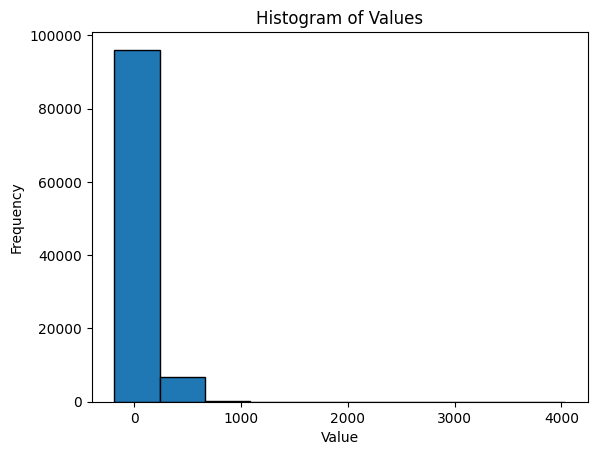

In [ ]:
import matplotlib.pyplot as plt

# Create a sample numpy array
data2 = np.array(data['Imbalance Price Amount']).flatten()  # 1000 random numbers from a standard normal distribution

# Plot histogram
plt.hist(data2, bins=10, edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
np.mean(data['Imbalance Price Amount'])

88.86055670997246

In [ ]:
stddev = np.std(data['Imbalance Price Amount'])


In [ ]:
average_distance = data['Imbalance Price Amount'].diff().abs().dropna()
print(average_distance)

1          0.02000
2          7.99000
3          0.08000
4         19.30298
5          0.80077
            ...   
103099    45.95000
103100     0.54000
103101    49.41000
103102     2.88000
103103     2.44000
Name: Imbalance Price Amount, Length: 103103, dtype: float64


In [ ]:
np.std(average_distance)

67.49461870551072

In [ ]:
average_distance = data['Price'].diff().abs().dropna().mean()
print(average_distance)

6.716534484932543


In [ ]:
print(stddev)

108.87969465248797


In [ ]:
print(scaled_target)

[[-0.20426555]
 [-0.20456594]
 [-0.32457194]
 ...
 [ 0.19375188]
 [-0.16521478]
 [-0.22424151]]
